### 导入数据

In [139]:
import sqlite3
import pandas as pd

missing_value = ['none']
Source_Path = 'DataSource/'
conn = sqlite3.connect(Source_Path + 'movieInfo.db')
comment = pd.read_csv(Source_Path + 'comment.csv')
movID = pd.read_csv(Source_Path + 'movID.csv')
movies = pd.read_csv(Source_Path + 'movies.csv')
person = pd.read_csv(Source_Path + 'person.csv')
ratInfo = pd.read_csv(Source_Path + 'ratInfo.csv')
relationships = pd.read_csv(Source_Path + 'relationships.csv')
usrID = pd.read_csv(Source_Path + 'usrID.csv')
usrRate = pd.read_csv(Source_Path + 'usrRate.csv', na_values=missing_value)
movieInfo = pd.read_sql_query('SELECT * FROM movieInfo', conn)

### 数据预处理

In [118]:
import numpy as np

# 将usrRate中的movieID转换为字符串
for (i, item) in enumerate(usrRate['movieID']): 
    usrRate['movieID'][i] = str(item)

# 按年份分组
mov_group_by_year = movies.groupby('year').size().reset_index(name='counts')
mov_group_by_year = mov_group_by_year.sort_values(by='year', ascending=True)

# 计算每部电影的平均评分和评分人数
mov_mean_rate = pd.merge(usrRate, movieInfo, on=['movieID'])[['movieID', 'name', 'user_rate']].dropna().groupby(['name', 'movieID']).agg({'mean', 'count'}).reset_index() 
mov_mean_rate.columns = ['name', 'movieID', 'count', 'mean']
mov_mean_rate = mov_mean_rate[mov_mean_rate['count'] > 50]

ratings = pd.merge(usrRate, movieInfo, on=['movieID'])[['username','movieID', 'name', 'user_rate']].dropna()
ratings = pd.merge(ratings, usrID, on=['username'])[['userID','username', 'movieID', 'name', 'user_rate']].dropna()

user_ids = ratings["userID"].unique().tolist()
movie_ids = ratings["movieID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings["user"] = ratings["userID"].map(user2user_encoded)
ratings["movie"] = ratings["movieID"].map(movie2movie_encoded)

num_users = len(user_ids)
num_movies = len(movie_ids)
ratings["user_rate"] = ratings["user_rate"].values.astype(np.float32)
min_rating = min(ratings["user_rate"])
max_rating = max(ratings["user_rate"])

print(f"用户数量: {num_users}, 电影数量: {num_movies}, 最小评分: {min_rating}, 最大评分: {max_rating}")

C:\Users\AbracaSora\AppData\Local\Temp\ipykernel_14000\645210594.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



用户数量: 3212, 电影数量: 24941, 最小评分: 1.0, 最大评分: 5.0


### 图像绘制

In [64]:
import plotly.express as px

fig = px.bar(mov_group_by_year, x='year', y='counts', title='电影年份分布')
fig.show()

In [65]:
fig = px.scatter(mov_mean_rate,
                 x='mean',
                 y='count',
                 hover_name='name',
                 size='count',
                 color='mean',
                 labels={'mean': 'Mean Rate', 'count': 'Rate Count'},
                 title='电影评分分布')
fig.show()

### 建立协同过滤模型

In [133]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

EMBEDDING_SIZE = 50
 
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
 
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # 加入所有的偏置项
        x = dot_user_movie + user_bias + movie_bias
        # Simgoid激活函数使得输出值在0-1之间
        return tf.nn.sigmoid(x)
 
 
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

### 数据集划分

In [134]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["user_rate"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)
(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

((229878, 2), (57470, 2), (229878,), (57470,))

### 模型训练

In [135]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.6017 - val_loss: 0.5455
Epoch 2/5
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.5418 - val_loss: 0.5420
Epoch 3/5
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.5402 - val_loss: 0.5410
Epoch 4/5
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.5413 - val_loss: 0.5463
Epoch 5/5
7184/7184 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.5453 - val_loss: 0.5455


### 模型保存与加载

In [138]:
model.save("model.keras")

In [ ]:
model = keras.models.load_model("model.keras")

### 模型评估

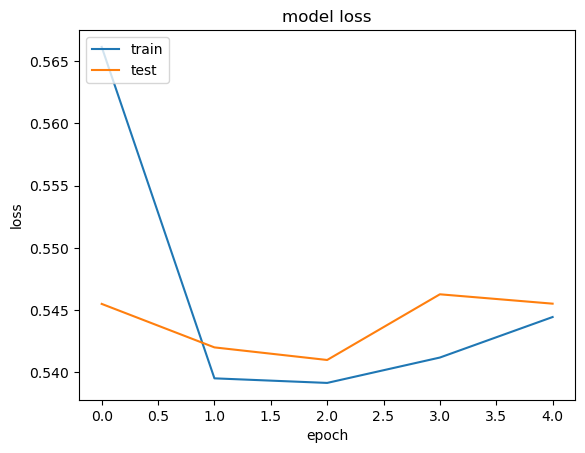

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 结果展示

In [142]:
# 获取用户ID并推荐电影
user_id = ratings.userID.sample(1).iloc[0]
movies_watched_by_user = ratings[ratings.userID == user_id]
movies_not_watched = ratings[
    ~ratings["movieID"].isin(movies_watched_by_user.movieID.values)
]["movieID"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_id]] * len(movies_not_watched), movies_not_watched)
)
rating = model.predict(user_movie_array).flatten()
top_ratings_indices = rating.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# 打印推荐结果
print("Movies this user has watched:")
print("----" * 8)
for row in movies_watched_by_user.itertuples():
    print(row.name)
print("----" * 8)
 
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by='user_rate', ascending=False)
    .head(5)
    .movieID.values
)
movie_df_rows = movieInfo[movieInfo["movieID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.name, ":", row.genre)
 
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movieInfo[movieInfo["movieID"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.name, ":", row.genre)

771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step
Movies this user has watched:
--------------------------------
血肉之躯 Warm Bodies
撒娇女人最好命
和莎莫的500天 (500) Days of Summer
九品芝麻官
英国病人 The English Patient
爱的艺术 L'art d'aimer
极地特快 The Polar Express
超体 Lucy
人间·小团圆 香港仔
荒川爆笑团 第二季 荒川アンダー ザ ブリッジ×ブリッジ
听说 聽說
沉睡魔咒 Maleficent
驯龙高手2 How to Train Your Dragon 2
101次求婚
将爱情进行到底
蜂蜜与四叶草 ハチミツとクローバー
单身男女 單身男女
大话西游之月光宝盒 西遊記第壹佰零壹回之月光寶盒
一树梨花压海棠 Lolita
借东西的小人阿莉埃蒂 借りぐらしのアリエッティ
僵尸新娘 Corpse Bride
让子弹飞
山楂树之恋
深海寻人
归来
审死官 審死官
少年透明人 Il ragazzo invisibile
前任攻略
通灵男孩诺曼 ParaNorman
三更
四月物语 四月物語
罗马假日 Roman Holiday
无人驾驶
起风了 風立ちぬ
明天，妈妈不在 明日、ママがいない
如梦
秒速5厘米 秒速5センチメートル
海盗电台 The Boat That Rocked
芳芳 Fanfan
飞屋环游记 Up
律政俏佳人 Legally Blonde: The Musical
言叶之庭 言の葉の庭
夏日大作战 サマーウォーズ
萤火之森 蛍火の杜へ
猫在巴黎 Une vie de chat
功夫
月升王国 Moonrise Kingdom
万能钥匙 The Skeleton Key
林中小屋 The Cabin in the Woods
她爱上了我的谎 カノジョは嘘を愛しすぎてる
猫的报恩 猫の恩返し
仪式 The Rite
被嫌弃的松子的一生 嫌われ松子の一生
全城热恋
惊情四百年 Dracula
夏目友人帐 第二季 続 夏目友人帳
岁月的童话 おもひでぽろぽろ
西雅图未眠夜 Sleepless in Seattle
失恋33天
黑衣人 Men in Blac